In [103]:
%pip install torch numpy pandas matplotlib pytorch-lightning librosa


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [104]:
# imports
import torch
import torch.nn as nn
import librosa
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
import typing

# Project Overview and Motivation

### Modeling Effects Pedals

Since the 1950s, guitarists and other instrumentalists have used effects pedals to achieve certain sounds from their instruments, from overdrive and distortion to reverb and delay. These effects are often encapsulated in physical pedals, each one with different analog circuitry, down to the types of capacitors that go on the pedals, to achieve these different sounds. Musicians will then use these pedals downstream of their instrument signal to apply the effect.

Here is a common signal flow for an overdrive pedal with a guitar:

![signal flow](images/signal-flow.png "Signal Flow")

The guitar produces an input signal, which goes through the overdrive pedal, applying the overdriven effect (a sound that is more distorted and louder) on the raw signal, which then goes through the amplifier, which applies its own sound, and outputs it over its speakers.

### Creating An Effects Pedal Model

Now, the goal of this project is to use machine learning to replace the pedal in the signal chain with software -- a model that emulates the same sound that musicians come to expect when using that pedal.

![signal flow in software](images/signal-flow-sw.png "Signal Flow in Software")

Using an input waveform from the guitar, and an output waveform from the guitar pedal, we can perform supervised learning to achieve this pedal model, completely cutting out the physical pedal in the signal chain altogether!

### Our Setup

For this project, we wanted to model a Boss DS-2 Turbo Distortion Pedal. To achieve this setup and record our dataset, we split the output of the guitar -- one side goes into an input of an audio interface so we can record the raw guitar signal, and the other goes to the pedal, the output of which goes to another input of the audio interface so we can record the distorted guitar signal.


## Analyze audio signals
Our first step is to actually analyze our audio signals. We can use librosa, a package for audio analysis, for this task. What we are essentially doing here is reading from our .wav files and plotting that data on a graph which depicts the amplitude of the wave over time.

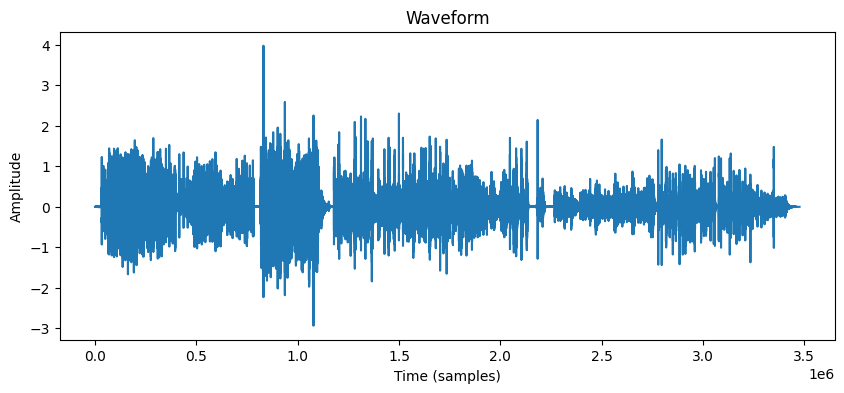

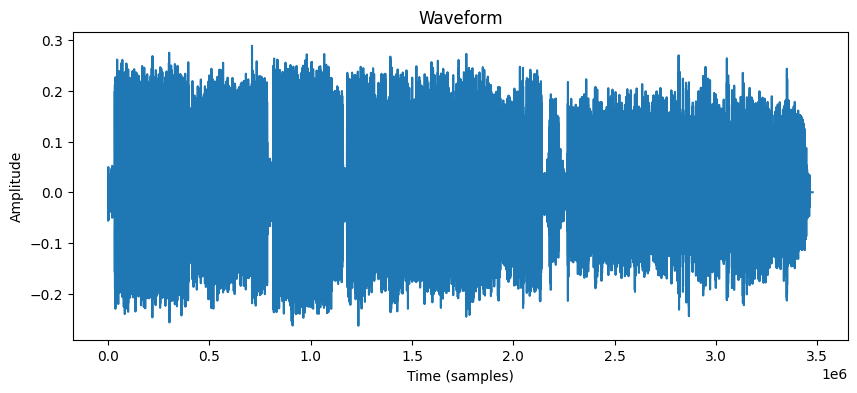

In [105]:
# data exploration to expand on later
def load_audio(file_path: str) -> tuple:
    audio_signal, sampling_rate = librosa.load(file_path, sr=None)
    return audio_signal, sampling_rate

def plot_waveform(wave: np.ndarray) -> None:
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(wave)
    plt.title("Waveform")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

LENGTH_OF_TRAIN = 120

inp_audio_signal, inp_sampling_rate = load_audio("./input-new.wav")
out_audio_signal, out_sampling_rate = load_audio("./target-new.wav")

plot_waveform(inp_audio_signal)
plot_waveform(out_audio_signal)

/tmp/ipykernel_4173/3217719680.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([inp_audio_signal, out_audio_signal], vert=False, labels=["Input", "Output"])


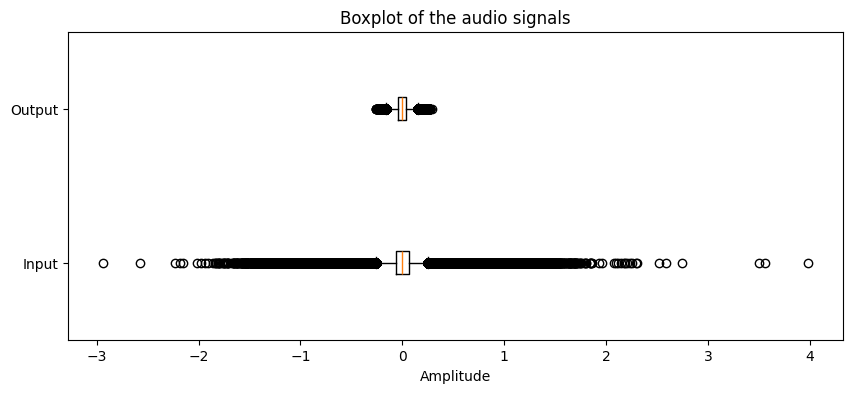

In [106]:
# Cutting out outliers
# Make boxplot of the audio signals
plt.figure(figsize=(10, 4))
plt.boxplot([inp_audio_signal, out_audio_signal], vert=False, labels=["Input", "Output"])
plt.title("Boxplot of the audio signals")
plt.xlabel("Amplitude")
plt.show()


### Analysis
as can be seen here, the graph for input and output datasets differ drastically

# Machine Learning
We are planning on using a neural network for our machine learning model. 

In [107]:
# turn into tensors for torch
def to_tensor(data: np.ndarray) -> torch.Tensor:
    return torch.tensor(data, dtype=torch.float32).unsqueeze(1)


inp_tensor = to_tensor(inp_audio_signal)
out_tensor = to_tensor(out_audio_signal)

print(f"Input Tensor Shape: {inp_tensor.shape}")
print(f"Target Tensor Shape: {out_tensor.shape}")

cuda_available = torch.cuda.is_available()

device = torch.device("cuda" if cuda_available else "cpu")

print(f"Device: {device}")

Input Tensor Shape: torch.Size([3476960, 1])
Target Tensor Shape: torch.Size([3476960, 1])
Device: cuda


## Neural Network
WaveNet is our initial neural network for this project. There are five layers in this model, and we will explain our reasoning for using these five layers shortly
1. Input Layer
    - this is our input layer that takes in our raw audio signal and converts it via a 1x1 convolution, which transforms a single-channel raw waveform into multiple feature maps. Feature maps are the output of the 1x1 convolution that lets the model decide which features actually matter (pitch, amplitude, etc.). This makes it so that we do not have to manually select our features, which, due to the vast domain of audio, could lead our model to be overfitted.
2. Dilated Convolution Layers:
3. Residual Connections
4. Skip Connections
5. Output Layer


In [108]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(ResidualBlock, self).__init__()
        padding = dilation * (kernel_size - 1)
        self.dilated_conv = nn.Conv1d(
            in_channels, out_channels, kernel_size, dilation=dilation, padding=padding
        )
        self.skip_conv = nn.Conv1d(out_channels, out_channels, 1)
        self.residual_conv = nn.Conv1d(out_channels, in_channels, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        out = self.dilated_conv(x)
        skip = self.skip_conv(out)
        residual = self.residual_conv(out)
        out = self.activation(out + skip)  # Add residual + skip, then apply activation
        return out, residual


class WaveNet(nn.Module):
    def __init__(
        self,
        num_channels: int = 32,
        dilation_depth: int = 4,
        kernel_size: int = 2,
        num_classes: int = 256,
    ):
        super(WaveNet, self).__init__()
        self.input_layer = nn.Conv1d(
            in_channels=1, out_channels=num_channels, kernel_size=1
        )

        self.residual_blocks = nn.ModuleList()
        dilation = 1
        for i in range(dilation_depth):
            self.residual_blocks.append(
                ResidualBlock(num_channels, num_channels, kernel_size, dilation)
            )
            dilation *= 2  # Double the dilation at each block

        self.output_layer = nn.Conv1d(num_channels, 1, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.input_layer(x)
        skip_connections = []
        for block in self.residual_blocks:
            out, skip = block(out)
            # skip_connections.append(skip)

            # # Ensure the skip connections have the same shape
            # out = sum(skip_connections)  # Sum over the skip connections
        out = self.output_layer(out)
        return out

In [109]:
batch_size = 128
learning_rate = 0.001
num_epochs = 100

num_channels = 32
dilation_depth = 4
kernel_size = 2
num_classes = 2 ** 8

In [110]:
def train_model(model: nn.Module, dataLoader: DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer, num_epochs: int = 10) -> None:
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataLoader:
            optimizer.zero_grad()

            inputs = inputs.unsqueeze(1)
            targets = targets.unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

In [111]:
# training loop

# class for pytorch
class AudioDataset(Dataset):
    def __init__(self, inputs: Tensor, outputs: Tensor):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self) -> int:
        return len(self.inputs)

    def __getitem__(self, index: int) -> tuple:
        return self.inputs[index], self.outputs[index]

# model = WaveNet(num_channels, dilation_depth, kernel_size, num_classes)

# inp_tensor = inp_tensor.to(device)
# out_tensor = out_tensor.to(device)
# model = model.to(device)

# training_dataset = Audio(inp_tensor, out_tensor)
# train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Load model
# model.load_state_dict(torch.load("wavenet_guitar_model.pth"))

# train_model(model, train_loader, criterion, optimizer, num_epochs)


In [112]:
# torch.save(model.state_dict(), "wavenet_guitar_model.pth")
# print("Model saved successfully.")

In [113]:
model = WaveNet()  # Ensure this matches the architecture used during training

# Load the saved state dictionary
model.load_state_dict(torch.load("wavenet_guitar_model.pth"))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully.")

Model loaded successfully.


/tmp/ipykernel_4173/76303354.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("wavenet_guitar_model.pth"))


In [114]:
# ESR loss calculates the Error-to-signal between the output/target
class ESRLoss(nn.Module):
    def __init__(self):
        super(ESRLoss, self).__init__()
        self.epsilon = 0.00001

    def forward(self, output, target):
        loss = torch.add(target, -output)
        loss = torch.pow(loss, 2)
        loss = torch.mean(loss)
        energy = torch.mean(torch.pow(target, 2)) + self.epsilon
        loss = torch.div(loss, energy)
        return loss


In [115]:
import torch
import torch.nn as nn
import math
from torch.utils.data import DataLoader
import json


class Pedal(nn.Module):
    # determine how many channels our audio data represents. 1 for mono 2 for stereo
    # should be the same for input and output
    INPUT_OUTPUT_SIZE = 1

    def __init__(
        self,
        hidden_size,
        window_size,
        normalization_data,
        init_len=200,
        num_layers=1,
        hidden=None,
    ):
        super(Pedal, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.window_size = window_size
        self.init_len = init_len

        self.lstm = nn.LSTM(Pedal.INPUT_OUTPUT_SIZE, hidden_size, self.num_layers)
        self.last_layer = nn.Linear(hidden_size, Pedal.INPUT_OUTPUT_SIZE, bias=True)
        self.hidden = hidden

        self.normalization_data = normalization_data

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, self.hidden = self.lstm(x, self.hidden)
        output = self.last_layer(output)

        return output + x

    def train_epoch(
        self,
        data_loader: DataLoader,
        criterion: nn.Module,
        optimizer: torch.optim.Optimizer,
    ) -> float:
        self.train()
        batch_loss = 0.0
        for inputs, targets in data_loader:
            # populate hidden layer with information using some early data
            init_inputs = inputs[0 : self.init_len :, :, :]
            rest_inputs = inputs[self.init_len :, :, :]
            rest_targets = targets[self.init_len :, :, :]

            self(init_inputs)

            window_start_idx = self.init_len
            window_loss = 0

            # so that we don't have zero range
            window_iterations = (
                len(rest_inputs) // self.window_size
                if len(rest_inputs) % self.window_size == 0
                else 1
            )
            for _ in range(window_iterations):
                window_inputs = rest_inputs[
                    window_start_idx : window_start_idx + self.window_size, :, :
                ]
                window_targets = rest_targets[
                    window_start_idx : window_start_idx + self.window_size, :, :
                ]

                outputs = self(window_inputs)
                loss = criterion(outputs, window_targets)

                loss.backward()
                optimizer.step()

                # prepare for next batch
                # save hidden state for next batch
                self.detach_hidden()
                self.zero_grad()
                window_loss += loss
                window_start_idx += self.window_size

            batch_loss += (
                window_loss / window_iterations if window_iterations > 0 else 0
            )
            self.reset_hidden()

        return batch_loss / len(data_loader)

    def train_model(
        self,
        data_loader: DataLoader,
        criterion: nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler.ReduceLROnPlateau,
        num_epochs: int,
        save_path: str,
    ) -> float:
        self.train()
        lowest_loss = float("inf")
        for _ in range(num_epochs):
            loss = self.train_epoch(data_loader, criterion, optimizer)
            scheduler.step(loss)
            # print(f"Epoch: {epoch + 1}, Loss: {loss}")

            lowest_loss = min(lowest_loss, loss)
            if loss == lowest_loss:
                self.save_model(save_path)

        print(f"Lowest Loss: {lowest_loss} reached after {num_epochs} epochs.")
        return lowest_loss

    def normalize_data(self, data: torch.Tensor) -> torch.Tensor:
        return (data - self.normalization_data["min"]) / (
            self.normalization_data["max"] - self.normalization_data["min"]
        )

    # detach hidden state, this resets gradient tracking on the hidden state
    def detach_hidden(self):
        if self.hidden.__class__ == tuple:
            self.hidden = tuple([h.clone().detach() for h in self.hidden])
        else:
            self.hidden = self.hidden.clone().detach()

    # changes the hidden state to None, causing pytorch to create an all-zero hidden state when the rec unit is called
    def reset_hidden(self):
        self.hidden = None

    def save_model(self, path: str) -> None:
        # Save hyperparameters as json
        hyperparameters = {
            "hidden_size": self.hidden_size,
            "window_size": self.window_size,
            "init_len": self.init_len,
            "num_layers": self.num_layers,
            "normalization_data": self.normalization_data,
        }

        torch.save(self.state_dict(), f"{path}.pth")
        json.dump(hyperparameters, open(f"{path}.json", "w"))
        # print("Model saved successfully.")

    def load_model(self, path: str) -> None:
        self.load_state_dict(torch.load(f"{path}.pth"))
        hyperparameters = json.load(open(f"{path}.json", "r"))

        self.hidden_size = hyperparameters["hidden_size"]
        self.window_size = hyperparameters["window_size"]
        self.init_len = hyperparameters["init_len"]
        self.num_layers = hyperparameters["num_layers"]
        self.normalization_data = hyperparameters["normalization_data"]

    def predict(self, x: torch.Tensor, normalize=False, criterion=None) -> torch.Tensor:
        # Put model and tensor on cpu
        self.to("cpu")
        x = x.to("cpu")

        self.eval()

        if normalize:
            x = self.normalize_data(x)

        # Reshape input tensor to LSTM input shape
        x = x.unsqueeze(1)

        with torch.no_grad():
            output = self(x)

        if criterion:
            loss = criterion(output, x)

        self.to("cuda" if torch.cuda.is_available() else "cpu")
        x = x.to("cuda" if torch.cuda.is_available() else "cpu")
        self.hidden = self.hidden[0].to("cuda" if torch.cuda.is_available() else "cpu"), self.hidden[1].to("cuda" if torch.cuda.is_available() else "cpu")

        if criterion:
            return output.to("cuda" if torch.cuda.is_available() else "cpu"), loss
        else:
            return output.to("cuda" if torch.cuda.is_available() else "cpu")

    def process_data(self, input_data: torch.Tensor, target_data: torch.Tensor, criterion, num_batches, normalize=False) -> torch.Tensor:
        self.eval()

        if normalize:
            input_data = self.normalize_data(input_data)

        # Reshape input tensor to LSTM input shape
        input_data = input_data.unsqueeze(1)

        # Batch prediction
        batch_size = input_data.shape[0] // num_batches

        output = torch.zeros_like(input_data)

        total_loss = 0.0
        with torch.no_grad():
            for i in range(num_batches):
                output[i * batch_size : (i + 1) * batch_size] = self(
                    input_data[i * batch_size : (i + 1) * batch_size]
                )
                self.detach_hidden()

                total_loss += criterion(output[i * batch_size : (i + 1) * batch_size], target_data[i * batch_size : (i + 1) * batch_size])

            if num_batches * batch_size < input_data.shape[0]:
                output[num_batches * batch_size :] = self(
                    input_data[num_batches * batch_size :]
                )

                total_loss += criterion(output[num_batches * batch_size :], target_data[num_batches * batch_size :])

            self.reset_hidden()

        return output, total_loss / num_batches

In [116]:
# """
# TODO: Nested CV for hyperparameters to check
# - batch size
# - initial learning rate
# - hidden size
# - up for real
# - num layers (layers of LSTM)
# - init length

# TODO: feature exploration / engineering
# - remove / replace outliers in input data
# - take a closer look at data (zoom into graph and see)
# """

# # load
# batch_size = 1000
# train_window = 1000
# hidden_size = 96
# num_layers = 2
# num_epochs = 80
# learning_rate = 0.005
# reload_model = False

# # Device configuration
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# inp_tensor_lstm = inp_tensor.to(device).contiguous().unsqueeze(1)
# out_tensor_lstm = out_tensor.to(device).contiguous().unsqueeze(1)

# # Model
# lstm_model = Pedal(
#     hidden_size,
#     train_window,
#     {"min": min(out_tensor_lstm), "max": max(out_tensor_lstm)},
# ).to(device)

# if reload_model:
#     lstm_model.load_model("lstm_guitar_model.pth")

# # Training loop
# criterion = ESRLoss()
# optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, "min", factor=0.5, patience=5, verbose=True
# )

# # Assuming inp_tensor and out_tensor are already defined

# seq_len = len(inp_tensor_lstm) // batch_size

# print(f"Input Tensor Shape: {inp_tensor_lstm.shape}")
# print(f"Target Tensor Shape: {out_tensor_lstm.shape}")

# # Normalize both tensors to input tensor
# min_val = torch.min(out_tensor_lstm)
# max_val = torch.max(out_tensor_lstm)

# inp_tensor_lstm = (inp_tensor_lstm - min_val) / (max_val - min_val)
# out_tensor_lstm = (out_tensor_lstm - min_val) / (max_val - min_val)

# training_dataset = list(zip(inp_tensor_lstm, out_tensor_lstm))
# dataloader = DataLoader(training_dataset, batch_size=seq_len)

# save_epoch_interval = 10
# save_model = False

# print("Hyperparameters:")
# print(f"Batch Size: {batch_size}")
# print(f"Learning Rate: {learning_rate}")
# print(f"Number of Epochs: {num_epochs}")
# print(f"Hidden Size: {hidden_size}")
# print(f"Number of LSTM Layers: {num_layers}")
# print(f"Update Frequency: {train_window}")
# print(f"Save Model: {save_model}")

# lstm_model.train()
# lowest_loss = float("inf")
# # lstm_model.train_model(dataloader, criterion, optimizer, scheduler, num_epochs, "model.pth")

# for e in range(num_epochs):
#     loss = lstm_model.train_epoch(dataloader, criterion, optimizer)
#     scheduler.step(loss)
#     print(f"Epoch: {e}, Loss: {loss}")

#     if loss < lowest_loss:
#         lowest_loss = loss
#         lstm_model.save_model("model.pth")

In [117]:
def run_cv_lstm(
    model: Pedal,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler,
    input_tensor: torch.Tensor,
    target_tensor: torch.Tensor,
    batch_size: int,
    num_epochs: int,
    folds: int = 5,
):
    fold_losses = []

    for fold in range(folds):
        validation_data_size = len(input_tensor) // folds

        validation_test_start_idx = fold * validation_data_size
        validation_test_end_idx = (fold + 1) * validation_data_size

        training_input = torch.cat(
            [
                input_tensor[:validation_test_start_idx],
                input_tensor[validation_test_end_idx:],
            ]
        )

        training_target = torch.cat(
            [
                target_tensor[:validation_test_start_idx],
                target_tensor[validation_test_end_idx:],
            ]
        )

        validation_input = input_tensor[
            validation_test_start_idx:validation_test_end_idx
        ]

        validation_target = target_tensor[
            validation_test_start_idx:validation_test_end_idx
        ]

        # Resqueeze validation tensors to match expected prediction shape
        validation_input = validation_input.squeeze(1).contiguous()
        validation_target = validation_target.squeeze(1).contiguous()

        seq_len = math.ceil(len(training_input) / batch_size)
        training_dataset = AudioDataset(training_input, training_target)

        dataloader = DataLoader(training_dataset, batch_size=seq_len)

        model.train_model(dataloader, criterion, optimizer, scheduler, num_epochs, "lstm_guitar_model")

        # Validation
        # Load the best model
        model.load_model("lstm_guitar_model")

        _, validation_loss = model.predict(validation_input, criterion=criterion)

        fold_losses.append(validation_loss)

        print(f"Fold: {fold + 1}, Validation Loss: {validation_loss}")

    return fold_losses

In [118]:
# training_input = to_tensor(inp_audio_signal)
# training_target = to_tensor(out_audio_signal)

# test_input = to_tensor(inp_audio_signal)
# test_target = to_tensor(out_audio_signal)

# training_input = training_input.unsqueeze(1).to(device).contiguous()
# training_target = training_target.unsqueeze(1).to(device).contiguous()

In [119]:
# batch_size = 32
# hidden_size = 32
# train_window = 500
# num_epochs = 1

# normalization_data = {"min": min(training_target), "max": max(training_target)}

# lstm_model = Pedal(hidden_size, train_window, normalization_data).to(device)

# criterion = ESRLoss()
# optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, "min", factor=0.5, patience=5, verbose=True
# )

# fold_losses = run_cv_lstm(
#     lstm_model,
#     criterion,
#     optimizer,
#     scheduler,
#     training_input,
#     training_target,
#     batch_size,
#     num_epochs,
#     2,
# )

In [ ]:
import json
import itertools

num_epochs = 20

training_loop_folds = 3
validation_loop_folds = 3

batch_size = 128

LENGTH_OF_TESTSET = len(inp_audio_signal) // training_loop_folds

with open("hyperparameters.json") as f:
    hyperparameters = json.load(f)

keys = list(hyperparameters.keys())

combinations = list(itertools.product(*hyperparameters.values()))

hyperparameter_dicts = [dict(zip(keys, combo)) for combo in combinations]

training_losses = []
for train_fold in range(training_loop_folds):
    print(f"Running Training Fold: {train_fold + 1}")
    test_start_idx = train_fold * LENGTH_OF_TESTSET
    test_end_idx = (train_fold + 1) * LENGTH_OF_TESTSET

    training_input = to_tensor(
        np.concatenate(
            (inp_audio_signal[:test_start_idx], inp_audio_signal[test_end_idx:])
        )
    )

    training_target = to_tensor(
        np.concatenate(
            (out_audio_signal[:test_start_idx], out_audio_signal[test_end_idx:])
        )
    )

    test_input = to_tensor(inp_audio_signal[test_start_idx:test_end_idx]).to(device).contiguous()
    test_target = to_tensor(out_audio_signal[test_start_idx:test_end_idx]).to(device).contiguous()

    training_input = training_input.unsqueeze(1).to(device).contiguous()
    training_target = training_target.unsqueeze(1).to(device).contiguous()

    hyperparam_losses = []

    dict_iter = iter(hyperparameter_dicts)

    # Load hyperparameters
    with open("cur_hp.json") as f:
        hyperparameters = json.load(f)

        # Get to hyperparameters that were last trained
        for hp_dict in dict_iter:
            if hp_dict == hyperparameters:
                break

    for hp_dict in dict_iter:
        print(f"Running Model for Hyperparameters: {hp_dict}")
        hidden_size = hp_dict["hidden_size"]
        train_window = hp_dict["train_window"]

        normalization_data = {"min": torch.min(training_target).item(), "max": torch.max(training_target).item()}

        lstm_model = Pedal(hidden_size, train_window, normalization_data).to(device)

        criterion = ESRLoss()
        optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, "min", factor=0.5, patience=5, verbose=True
        )

        # Normalize
        min_val = torch.min(training_target)
        max_val = torch.max(training_target)

        training_input = (training_input - min_val) / (max_val - min_val)
        training_target = (training_target - min_val) / (max_val - min_val)

        fold_losses = run_cv_lstm(
            lstm_model,
            criterion,
            optimizer,
            scheduler,
            training_input,
            training_target,
            batch_size,
            num_epochs,
            validation_loop_folds,
        )

        avg_cv_loss = sum(fold_losses) / len(fold_losses)

        hyperparam_losses.append((hp_dict, avg_cv_loss))
        print(f"Hyperparameters: {hp_dict}, Average CV Loss: {avg_cv_loss}")

        # Save the hyperparameters
        with open("cur_hp.json", "w") as f:
            json.dump(hp_dict, f)

    # For the best hyperparameters, train on the entire training set
    best_hp = min(hyperparam_losses, key=lambda x: x[1])[0]
    hidden_size = best_hp["hidden_size"]
    train_window = best_hp["train_window"]

    print(f"Training with Best Hyperparameters: {best_hp}")

    lstm_model = Pedal(hidden_size, train_window, normalization_data).to(device)

    criterion = ESRLoss()
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", factor=0.5, patience=5, verbose=True
    )

    # Normalize
    min_val = torch.min(training_target)
    max_val = torch.max(training_target)

    training_input = (training_input - min_val) / (max_val - min_val)
    training_target = (training_target - min_val) / (max_val - min_val)

    seq_len = len(training_input) // batch_size
    training_dataset = AudioDataset(training_input, training_target)

    dataloader = DataLoader(training_dataset, batch_size=seq_len)

    lowest_loss = lstm_model.train_model(
        dataloader, criterion, optimizer, scheduler, num_epochs, "lstm_guitar_model"
    )

    # Test the model
    lstm_model.load_model("lstm_guitar_model")

    predicted_target, test_error = lstm_model.predict(test_input, criterion=criterion)

    training_losses.append(test_error)
    print(f"Test Loss for Fold {train_fold}: {test_error}")

    # Save the model
    lstm_model.save_model(f"lstm_guitar_model_fold_{train_fold}")

    # Save the hyperparameters
    with open("hyperparameters.json", "w") as f:
        json.dump(best_hp, f)

print(f"Average Test Loss: {sum(training_losses) / len(training_losses)}")

# Load the best model
best_fold = training_losses.index(min(training_losses))

lstm_model.load_model(f"lstm_guitar_model_fold_{best_fold}")

Running Training Fold: 1
Running Model for Hyperparameters: {'hidden_size': 32, 'train_window': 1000}


/home/sum/Documents/school/cs363m/guitar-pedal-ml/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Lowest Loss: 0.03479282930493355 reached after 20 epochs.


/tmp/ipykernel_4173/1104415556.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(f"{path}.pth"))


Fold: 1, Validation Loss: 0.34220090508461


In [ ]:
import soundfile as sf

def save_audio_file(input_signal: torch.Tensor, new_sampling_rate: int, path: str) -> None:
    output_signal = input_signal
    sf.write(path, output_signal, new_sampling_rate)

In [ ]:
# Predict
test_audio_signal, test_sampling_rate = load_audio("./input-new.wav")
target_audio_signal, target_sampling_rate = load_audio("./target-new.wav")

device = 'cpu'

# test_audio_signal, test_sampling_rate = load_audio("./data/mpidsf32.wav")
# target_audio_signal, target_sampling_rate = load_audio("./data/mpodsf32.wav")

# test_audio_signal = librosa.util.normalize(test_audio_signal)
# target_audio_signal = librosa.util.normalize(target_audio_signal)

mn = min(target_audio_signal)
mx = max(target_audio_signal)
test_audio_signal = (test_audio_signal - mn) / (mx - mn)

lstm_model.load_model(f"model")
lstm_model.eval()

test_tensor = to_tensor(test_audio_signal).to(device).contiguous()
target_tensor = to_tensor(target_audio_signal).to(device).contiguous()

criterion = ESRLoss()

# predicted_audio_signal, _ = lstm_model.process_data(test_tensor, target_tensor, criterion, 512)
predicted_audio_signal = lstm_model.predict(test_tensor, normalize=False)

numpy_audio_signal = predicted_audio_signal.cpu().numpy().flatten()

print(f"Predicted Audio Signal Shape: {numpy_audio_signal.shape}")
print(f"Actual Audio Signal Shape: {target_audio_signal.shape}")

save_audio_file(numpy_audio_signal, test_sampling_rate, "predicted_audio.wav")

/tmp/ipykernel_4156/4043668563.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


TypeError: 'NoneType' object is not subscriptable

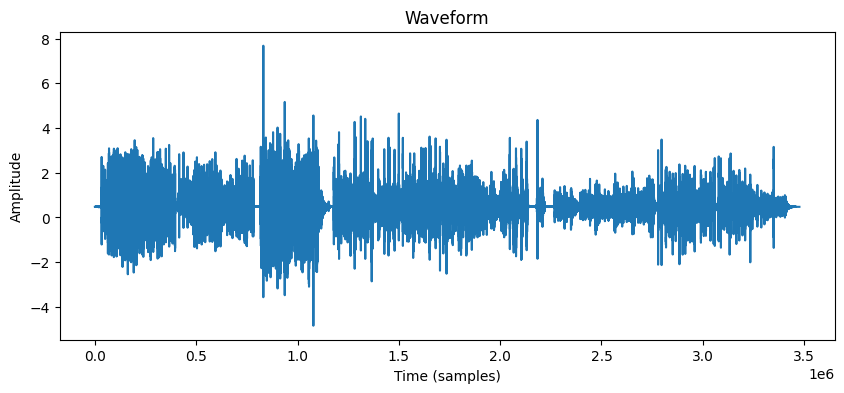

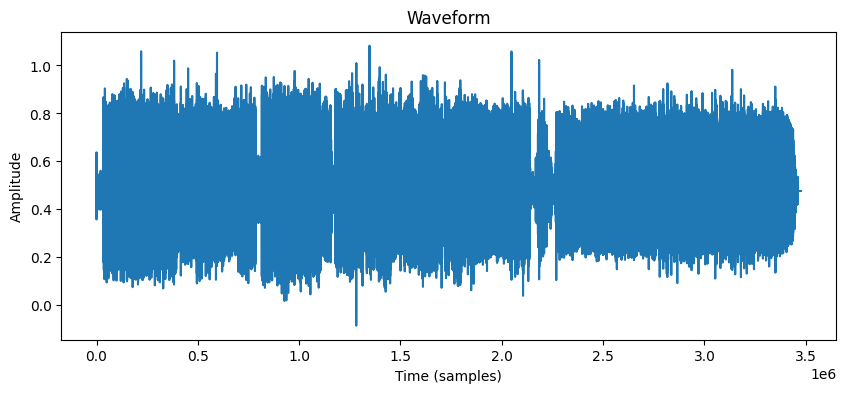

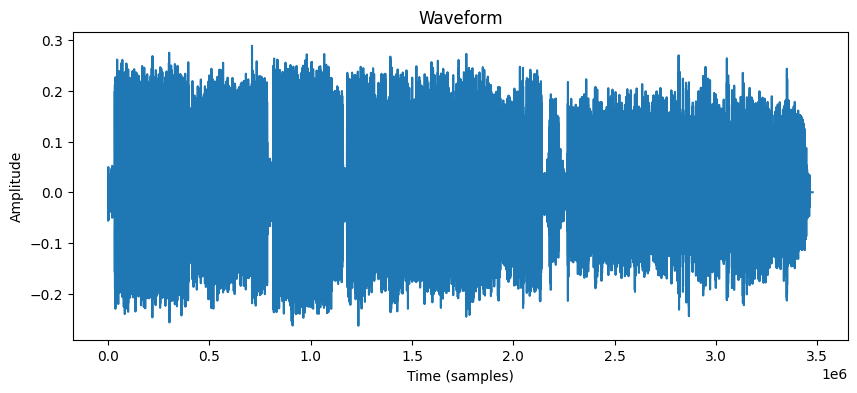

In [ ]:
# Plot the predicted audio signal
plot_waveform(test_audio_signal)
plot_waveform(numpy_audio_signal)
plot_waveform(target_audio_signal)